In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score, roc_auc_score, SCORERS, mean_squared_error, plot_precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline

In [5]:
df = pd.read_csv('hotel_bookings.csv', usecols = ['hotel', 'is_canceled', 'adults', 'children', 'babies', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'booking_changes', 'deposit_type', 'days_in_waiting_list', 'customer_type', 'required_car_parking_spaces', 'total_of_special_requests'])
df

,hotel,is_canceled,adults,children,babies,meal,country,market_segment,distribution_channel,reserved_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,0,2,0.0,0,BB,PRT,Direct,Direct,C,3,No Deposit,0,Transient,0,0
1,Resort Hotel,0,2,0.0,0,BB,PRT,Direct,Direct,C,4,No Deposit,0,Transient,0,0
2,Resort Hotel,0,1,0.0,0,BB,GBR,Direct,Direct,A,0,No Deposit,0,Transient,0,0
3,Resort Hotel,0,1,0.0,0,BB,GBR,Corporate,Corporate,A,0,No Deposit,0,Transient,0,0
4,Resort Hotel,0,2,0.0,0,BB,GBR,Online TA,TA/TO,A,0,No Deposit,0,Transient,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,A,0,No Deposit,0,Transient,0,0
119386,City Hotel,0,3,0.0,0,BB,FRA,Online TA,TA/TO,E,0,No Deposit,0,Transient,0,2
119387,City Hotel,0,2,0.0,0,BB,DEU,Online TA,TA/TO,D,0,No Deposit,0,Transient,0,4
119388,City Hotel,0,2,0.0,0,BB,GBR,Online TA,TA/TO,A,0,No Deposit,0,Transient,0,0


# EDA

Jalankan Exploratory Data Analysis untuk:

 - Memahami profil tamu/konsumen hotel (customer profiling).
 - Memahami kebiasaan tamu/konsumen hotel (customer behavior).

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 16 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   hotel                        119390 non-null  object 
 1   is_canceled                  119390 non-null  int64  
 2   adults                       119390 non-null  int64  
 3   children                     119386 non-null  float64
 4   babies                       119390 non-null  int64  
 5   meal                         119390 non-null  object 
 6   country                      118902 non-null  object 
 7   market_segment               119390 non-null  object 
 8   distribution_channel         119390 non-null  object 
 9   reserved_room_type           119390 non-null  object 
 10  booking_changes              119390 non-null  int64  
 11  deposit_type                 119390 non-null  object 
 12  days_in_waiting_list         119390 non-null  int64  
 13 

In [7]:
df.isna().sum()

hotel                            0
is_canceled                      0
adults                           0
children                         4
babies                           0
meal                             0
country                        488
market_segment                   0
distribution_channel             0
reserved_room_type               0
booking_changes                  0
deposit_type                     0
days_in_waiting_list             0
customer_type                    0
required_car_parking_spaces      0
total_of_special_requests        0
dtype: int64

In [9]:
df['is_canceled'].value_counts()

0    75166
1    44224
Name: is_canceled, dtype: int64

Text(0.5, 1.0, 'Cancellation Rate')

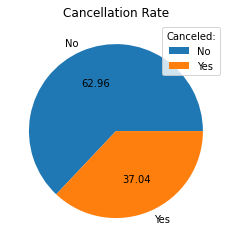

In [8]:
plt.pie(df['is_canceled'].value_counts(), labels = ['No','Yes'], autopct='%.2f')
plt.legend(title = "Canceled:")
plt.title('Cancellation Rate')

In [26]:
df.describe()

,is_canceled,adults,children,babies,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,1.856403,0.103890,0.007949,0.221124,2.321149,0.062518,0.571363
std,0.482918,0.579261,0.398561,0.097436,0.652306,17.594721,0.245291,0.792798
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,55.000000,10.000000,10.000000,21.000000,391.000000,8.000000,5.000000


/Users/marshaalexandra/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

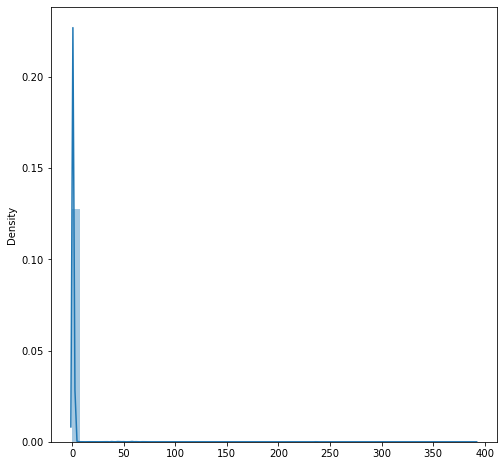

In [10]:
plt.figure(figsize =(8,8))
sns.distplot(df.drop(columns = ['hotel','meal','country','market_segment','distribution_channel','reserved_room_type','deposit_type','customer_type']))

#Distribusi data tidak normal.

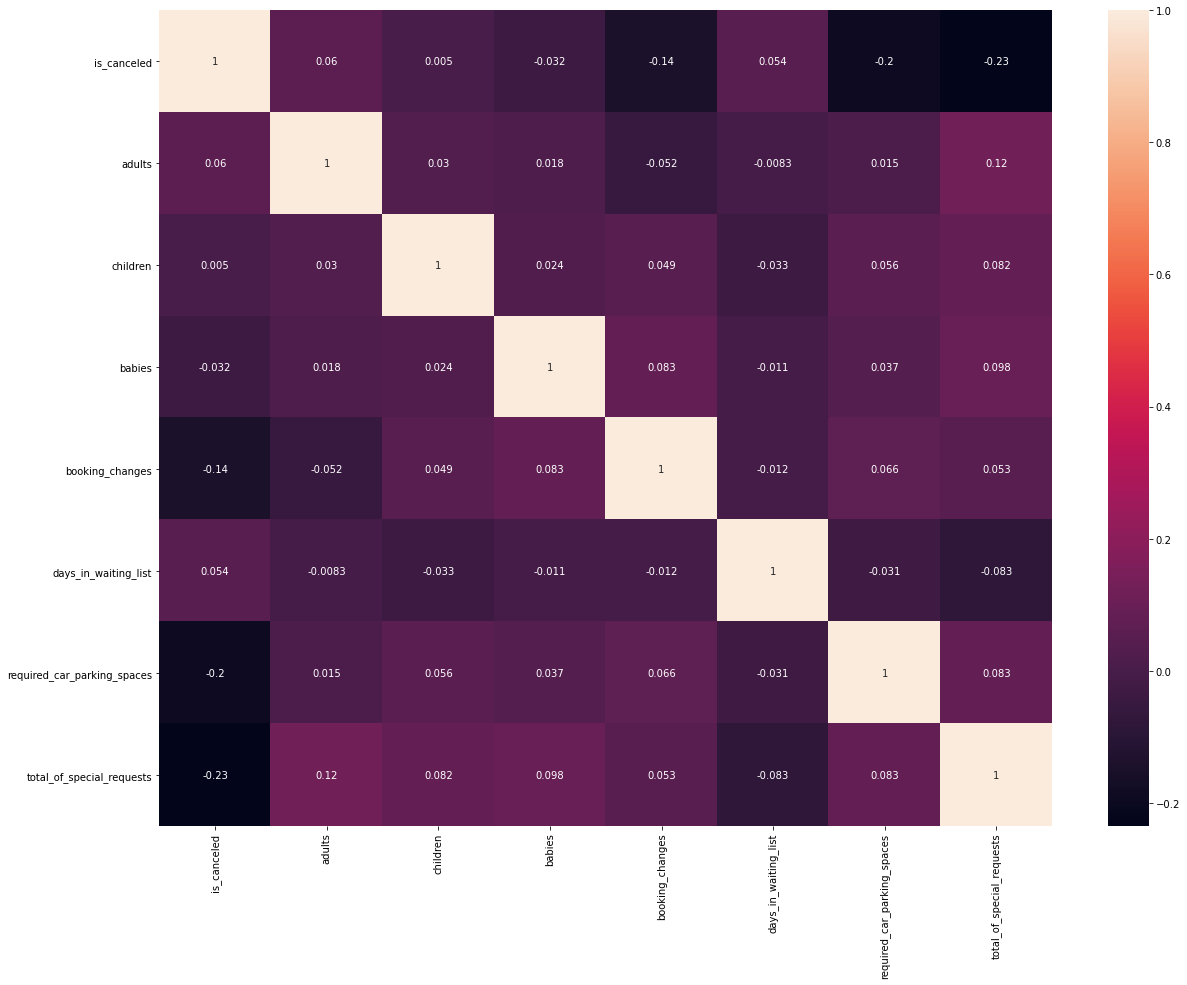

In [63]:
plt.figure(figsize=(20,15))
ax = sns.heatmap(df.corr(), annot = True)

#Tidak ada korelasi kuat antar feature-feature numerical

## Customer Profile

Untuk mencari tahu profile customer hotel, digunakan data customer yang tidak cancel bookingan hotelnya

In [12]:
df2 = df[df['is_canceled']==0]
df2

,hotel,is_canceled,adults,children,babies,meal,country,market_segment,distribution_channel,reserved_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,0,2,0.0,0,BB,PRT,Direct,Direct,C,3,No Deposit,0,Transient,0,0
1,Resort Hotel,0,2,0.0,0,BB,PRT,Direct,Direct,C,4,No Deposit,0,Transient,0,0
2,Resort Hotel,0,1,0.0,0,BB,GBR,Direct,Direct,A,0,No Deposit,0,Transient,0,0
3,Resort Hotel,0,1,0.0,0,BB,GBR,Corporate,Corporate,A,0,No Deposit,0,Transient,0,0
4,Resort Hotel,0,2,0.0,0,BB,GBR,Online TA,TA/TO,A,0,No Deposit,0,Transient,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,A,0,No Deposit,0,Transient,0,0
119386,City Hotel,0,3,0.0,0,BB,FRA,Online TA,TA/TO,E,0,No Deposit,0,Transient,0,2
119387,City Hotel,0,2,0.0,0,BB,DEU,Online TA,TA/TO,D,0,No Deposit,0,Transient,0,4
119388,City Hotel,0,2,0.0,0,BB,GBR,Online TA,TA/TO,A,0,No Deposit,0,Transient,0,0


<AxesSubplot:xlabel='hotel', ylabel='count'>

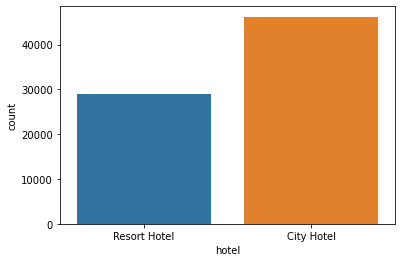

In [17]:
sns.countplot(x='hotel',data=df2)

In [40]:
df2['hotel'].value_counts()/df2['hotel'].shape[0]*100

City Hotel      61.501211
Resort Hotel    38.498789
Name: hotel, dtype: float64

#Customer di City Hotel hampir 2 kali lebih banyak daripada customer di Resort Hotel. Hal ini mungkin dipengaruhi oleh berbagai macam faktor, seperti kapasitas, lokasi, dan harga kamar.

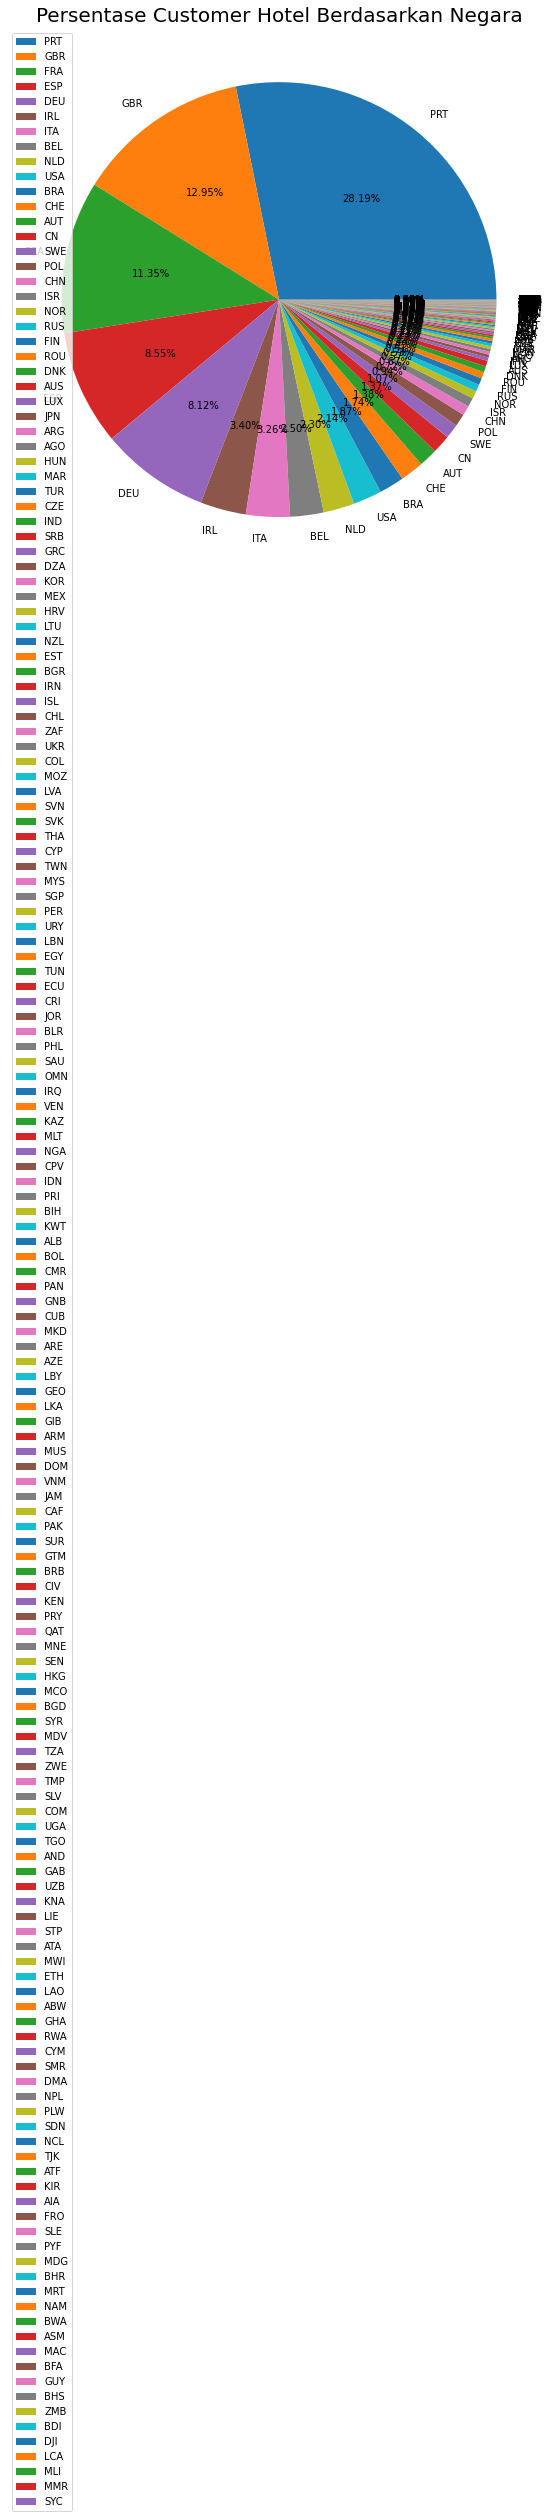

In [38]:
plt.figure(figsize=(20,10))
country = df2['country']
temp = country.value_counts()
labels = temp.keys()
plt.pie(x = temp, labels = labels , autopct="%.2f%%")
plt.title('Persentase Customer Hotel Berdasarkan Negara', fontsize=20)
plt.legend()

#Customer Hotel paling banyak berasal dari Portugal, United Kingdom, France, Spain dan Germany.

<AxesSubplot:xlabel='customer_type', ylabel='count'>

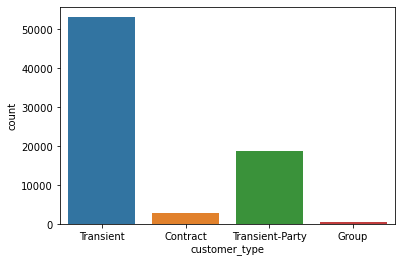

In [18]:
sns.countplot(x='customer_type',data=df2)

In [41]:
df2['customer_type'].value_counts()/df2['customer_type'].shape[0]*100

Transient          70.642312
Transient-Party    24.924833
Contract            3.743714
Group               0.689141
Name: customer_type, dtype: float64

#Customer type paling banyak adalah transient, atau customer yang booking tanpa asosiasi group atau kontrak.

<AxesSubplot:xlabel='market_segment', ylabel='count'>

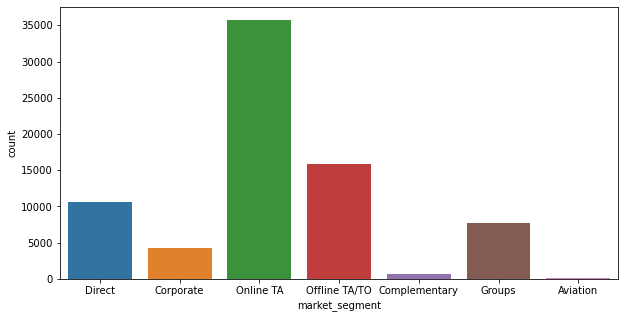

In [23]:
plt.figure(figsize=(10,5))
sns.countplot(x='market_segment',data=df2)

In [42]:
df2['market_segment'].value_counts()/df2['market_segment'].shape[0]*100

Online TA        47.545433
Offline TA/TO    21.163824
Direct           14.197909
Groups           10.262619
Corporate         5.724663
Complementary     0.859431
Aviation          0.246122
Name: market_segment, dtype: float64

#Kebanyakan customer booking dari online travel agents. Hal ini menunjukkan tujuan customer hotel memang kebanyakan untuk jalan-jalan/liburan.

<AxesSubplot:xlabel='distribution_channel', ylabel='count'>

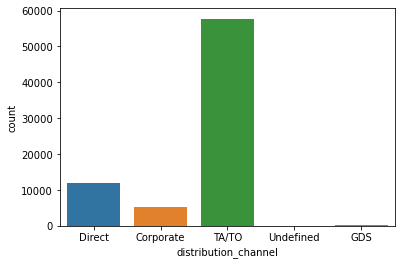

In [20]:
sns.countplot(x='distribution_channel',data=df2)

#Channel distribusi terbanyak adalah TA/TO, artinya memang customer hotel kebanyakan berasal dari customer yang ingin jalan-jalan.

<AxesSubplot:xlabel='adults', ylabel='count'>

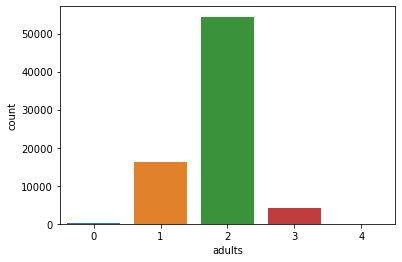

In [30]:
sns.countplot(x='adults',data=df2)

In [43]:
df2['adults'].value_counts()/df2['adults'].shape[0]*100

2    72.402416
1    21.755847
3     5.389405
0     0.391134
4     0.061198
Name: adults, dtype: float64

<AxesSubplot:xlabel='babies', ylabel='count'>

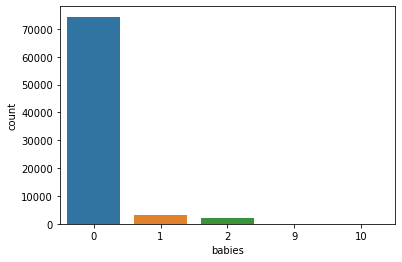

In [45]:
sns.countplot(x='children',data=df2)

<AxesSubplot:xlabel='babies', ylabel='count'>

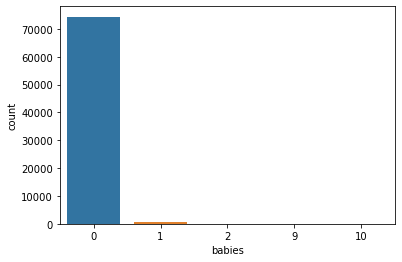

In [32]:
sns.countplot(x='babies',data=df2)

#Kebanyakan customer hotel pesan kamar untuk 2 orang, artinya main customer di hotel ini kemungkinan besar couples. Hal ini diperkuat dengan minimnya jumlah anak-anak dan bayi sebagai customer hotel.

## Customer Behavior

/Users/marshaalexandra/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='booking_changes', ylabel='Density'>

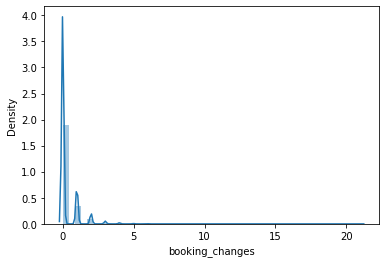

In [52]:
sns.distplot(df2['booking_changes'])

#Kebanyakan customers tidak membuat perubahan booking setelah booking hotel.

<AxesSubplot:xlabel='deposit_type', ylabel='count'>

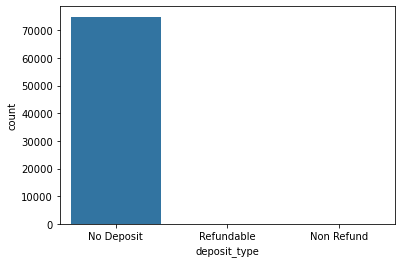

In [53]:
sns.countplot(x='deposit_type',data=df2)

#Kebanyakan customer tidak melakukan deposit untuk menjamin booking hotel.

<AxesSubplot:xlabel='meal', ylabel='count'>

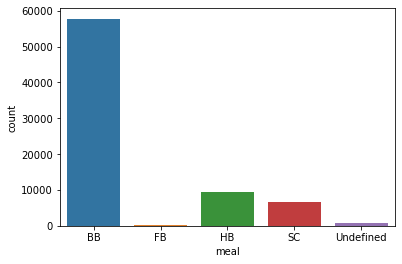

In [47]:
sns.countplot(x='meal',data=df2)

In [60]:
df2['meal'].value_counts()/df2['meal'].shape[0]*100

BB           76.896469
HB           12.610755
SC            8.892318
Undefined     1.174733
FB            0.425724
Name: meal, dtype: float64

#Kebanyakan customer order Bed and Breakfast, dan jarang order lunch dan dinner di hotel. Hal ini masuk akal karena customer yang datang kebanyakan tujuannya untuk jalan-jalan sehingga tidak menghabiskan banyak waktu di hotel,

<AxesSubplot:xlabel='reserved_room_type', ylabel='count'>

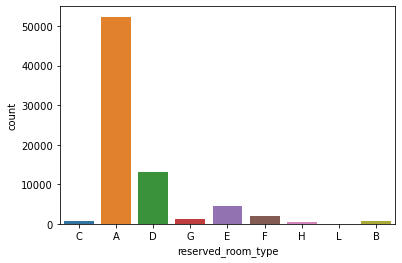

In [48]:
sns.countplot(x='reserved_room_type',data=df2)

In [61]:
df2['reserved_room_type'].value_counts()/df2['reserved_room_type'].shape[0]*100

A    69.664476
D    17.426762
E     6.147726
F     2.683394
G     1.770747
B     0.997792
C     0.830163
H     0.473618
L     0.005322
Name: reserved_room_type, dtype: float64

#Jenis kamar yang paling banyak dipesan adalah kamar A. Untuk improvement lebih lanjut, sebaiknya dibuat promo menarik jenis kamar lain untuk menarik perhatian customer.

<AxesSubplot:xlabel='required_car_parking_spaces', ylabel='count'>

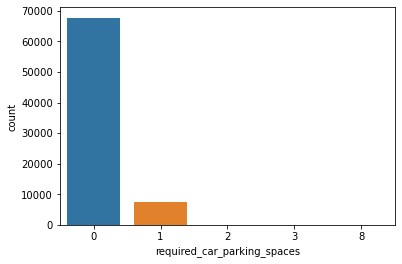

In [56]:
sns.countplot(x='required_car_parking_spaces',data=df2)

#Kebanyakan customer tidak membutuhkan parking spaces. Melihat data customer dari mancanegara, kemungkinan besar kebanyakan customer berasal dari negara lain yang jaraknya jauh sehingga tidak datang dengan mobil.

<AxesSubplot:xlabel='total_of_special_requests', ylabel='count'>

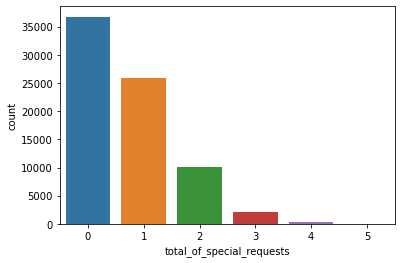

In [59]:
sns.countplot(x='total_of_special_requests',data=df2)

In [62]:
df2['total_of_special_requests'].value_counts()/df2['total_of_special_requests'].shape[0]*100

0    48.907751
1    34.467711
2    13.440917
3     2.728627
4     0.404438
5     0.050555
Name: total_of_special_requests, dtype: float64

#Kebanyakan customer tidak meminta atau meminta special request sekali di hotel ini.

Summary dan insights:
   1. Customer Profile: 
      - Customer berasal dari negara Portugal, United Kingdom, France, dan Germany.
      - Customer prefer City Hotel dibanding Resort Hotel. Manajemen hotel bisa mengevaluasi harga, kapasitas, fasilitas, waktu (apakah Resort Hotel hanya dibook saat holiday season saja?), dan lokasi yang membuat customer prefer City Hotel dibanding Resort Hotel
      - Kebanyakan customer booking transient, tidak berasosiasi dengan group atau kontrak.
      - Kebanyakan customer booking melalui travel agents atau tour operators secara online karena kemudahan booking lewat online. Banyaknya booking lewat channel ini menandakan bahwa kebanyakan customer di hotel tujuannya bukan menginap di hotel tersebut, tetapi ingin jalan-jalan di daerah tersebut. Untuk kedepannya, manajemen hotel dapat melakukan kolaborasi/partnership dengan pihak TA/TO untuk membuat promo menarik, melihat sebagian besar distribusi dan asal booking dari pihak TA/TO.
      - Kebanyakan customer booking ke hotel untuk 2 orang adult, artinya kebanyakan customer hotel itu adalah adult couples. Bisa jadi daerah dimana hotel itu berada adalah destinasi honeymoon. Untuk ke depannya, manajemen hotel bisa menawarkan honeymoon package jika belum ada.
   2. Customer Behavior:
      - Kebanyakan customer tidak membuat perubahan booking setelah booking. Hal ini mungkin dikarenakan bookingnya menggunakan pihak ketiga (TA/TO) sehingga mempersulit membuat perubahan.
      - Kebanyakan customer tidak melakukan deposit untuk menjamin booking di hotel tersebut. Hal ini sejalan dengan tujuan kebanyakan customer bukan fokus di hotel tersebut, melainkan travel di daerah tersebut.
      - Kebanyakan customer memesan breakfast saja, bukan lunch atau dinner karena tujuan utamanya untuk jalan-jalan.
      - Kebanyakan customer memesan room A mungkin karena kapasitas room A paling banyak atau fasilitasnya memadai dengan harga yang terjangkau. Untuk meningkatkan pemesanan di room lain, hotel dapat menawarkan promo yang menarik.
      - Kebanyakan customer tidak membutuhkan parking space. Hal ini masuk akal karena banyak customer yang datang dari mancanegara dengan tujuan liburan sehingga bisa diasumsikan mereka datang dari negara yang jauh jaraknya sehingga tidak menggunakan mobil. Manajemen hotel bisa mengevaluasi kapasitas parking space apakah terlalu banyak yang kosong sehingga tidak terpakai atau tidak.
      - Kebanyakan customer tidak meminta atau hanya meminta special request sebanyak 1 kali.

# Data Cleaning and Preprocessing

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 16 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   hotel                        119390 non-null  object 
 1   is_canceled                  119390 non-null  int64  
 2   adults                       119390 non-null  int64  
 3   children                     119386 non-null  float64
 4   babies                       119390 non-null  int64  
 5   meal                         119390 non-null  object 
 6   country                      118902 non-null  object 
 7   market_segment               119390 non-null  object 
 8   distribution_channel         119390 non-null  object 
 9   reserved_room_type           119390 non-null  object 
 10  booking_changes              119390 non-null  int64  
 11  deposit_type                 119390 non-null  object 
 12  days_in_waiting_list         119390 non-null  int64  
 13 

In [65]:
df.isna().sum()

hotel                            0
is_canceled                      0
adults                           0
children                         4
babies                           0
meal                             0
country                        488
market_segment                   0
distribution_channel             0
reserved_room_type               0
booking_changes                  0
deposit_type                     0
days_in_waiting_list             0
customer_type                    0
required_car_parking_spaces      0
total_of_special_requests        0
dtype: int64

Preprocessing scheme:
   * Drop missing value
   * one hot encoder: deposit type, customer type
   * binary coder: meal, country, reserved room type, distribution channel, market segment
   * passthrough: numerical features

In [70]:
df.dropna(subset=['country','children'],inplace = True)

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118898 entries, 0 to 119389
Data columns (total 16 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   hotel                        118898 non-null  object 
 1   is_canceled                  118898 non-null  int64  
 2   adults                       118898 non-null  int64  
 3   children                     118898 non-null  float64
 4   babies                       118898 non-null  int64  
 5   meal                         118898 non-null  object 
 6   country                      118898 non-null  object 
 7   market_segment               118898 non-null  object 
 8   distribution_channel         118898 non-null  object 
 9   reserved_room_type           118898 non-null  object 
 10  booking_changes              118898 non-null  int64  
 11  deposit_type                 118898 non-null  object 
 12  days_in_waiting_list         118898 non-null  int64  
 13 

In [71]:
df.isna().sum()

hotel                          0
is_canceled                    0
adults                         0
children                       0
babies                         0
meal                           0
country                        0
market_segment                 0
distribution_channel           0
reserved_room_type             0
booking_changes                0
deposit_type                   0
days_in_waiting_list           0
customer_type                  0
required_car_parking_spaces    0
total_of_special_requests      0
dtype: int64

In [81]:
transformer = ColumnTransformer([
    ('one hot', OneHotEncoder(drop = 'first'),['hotel','deposit_type','customer_type']),
    ('binary',ce.BinaryEncoder(),['meal','country','market_segment','distribution_channel','reserved_room_type'])
], remainder = 'passthrough')

In [82]:
transformer.fit_transform(df) #test transformer

/Users/marshaalexandra/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 4.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 2.]])

### Data Splitting

In [83]:
x = df.drop(columns=["is_canceled"])
y = df["is_canceled"]

In [84]:
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    stratify = y,
                                                    test_size = 0.3,
                                                    random_state = 2020)

# Model Benchmark and Evaluation

Model yang akan digunakan untuk memprediksi cancel booking(klasifikasi binary):
   - Logistic Regression: algoritma klasifikasi untuk mencari hubungan antara feature (input) dengan probabilitas hasil output tertentu. Hasil logistic regression diinterpretasi dengan odds-ratio untuk indikasi probabilitas kesuksesan sebuah event terjadi.
   - KNN : algoritma klasifikasi untuk mengklasifikasikan data berdasarkan dari kategori k-tetangga terdekat. Jumlah k akan ditentukan berdasarkan evaluasi validation data set.
   - Decision Tree : algoritma klasifikasi yang menggunakan struktur pohon, dimana setiap node dan cabangnya merepresentasikan feature dengan nilai measurement (berdasarkan information gain atau gini impurity) yang paling bagus. Decision tree akan terus membagi sehingga terbentuk daun yang digunakan untuk merepresentasikan kelas.

2 jenis kesalahan:

- Model memprediksi user akan cancel booking (membatalkan pesanan), padahal sebenarnya/realisasinya user tidak membatalkan pesanan (FP)
- Model memprediksi user tidak membatalkan pesanan, padahal sebenarnya/realisasinya user cancel booking (membatalkan pesanan (FN)


   a. Kesalahan yang lebih berpengaruh terhadap kerugian finansial perusahaan adalah FN karena hotel sudah mempersiapkan waktu, tenaga, dan uang untuk mempersiapkan kamar. Pada kesalahan FP, apabila ada customer yang diprediksi cancel, dan kamar yang diprediksi cancel kemudian dibooking orang lain, hal ini akan menyebabkan double book dan membuat customer komplain. Akan tetapi kebanyakan customer tidak membuat deposit, sehingga tidak ada refund process dari perusahaan sehingga dampak yang paling berpengaruh pada hotel adalah reputasi, bukan financial secara langsung seperti pada kesalahan FN.
   
   b. Kesalahan FN ingin ditekan dan metric evaluation yang dipakai adalah recall. Recall/sensitivity adalah rasio
    data prediksi positif yang benar dibanding semua data yang actual positif. Dalam kasus ini, recall akan membandingkan semua data yang prediksi cancelnya benar dibanding semua data yang realisasinya adalah cancel. Oleh karena itu, semakin kecil nilai FN, akan semakin besar nilai recallnya. 

### Model Benchmark

In [89]:
import warnings
warnings.filterwarnings("ignore")

In [86]:
models = [
    ['Log Regression', LogisticRegression(max_iter=10000)], 
    ['Decision Tree', DecisionTreeClassifier(max_depth=3, random_state=2020)], 
    ['K Neighbors', KNeighborsClassifier(n_neighbors=2)],
]

In [87]:
skfold = StratifiedKFold(n_splits = 5)

def evaluate (models):

    model_name=[]
    scores=[]
    score_std=[]
    for name, model in models:
        model = model
        estimator = Pipeline([
            ('transformer', transformer),
            ('model', model)])

        skfold=StratifiedKFold(n_splits=5)
        score= cross_val_score(estimator,x_train,y_train,scoring='recall',cv=skfold).mean()
        std= cross_val_score(estimator,x_train,y_train,scoring='recall',cv=skfold).std()
        scores.append(score)
        score_std.append(std)
        model_name.append(name)

    return pd.DataFrame({'Name': model_name,'score':scores, 'score_std':score_std})

In [90]:
evaluate(models)

,Name,score,score_std
0,Log Regression,0.548711,0.007676
1,Decision Tree,0.328178,0.004882
2,K Neighbors,0.567898,0.012314


In [91]:
def recall (models):

    model_name=[]
    recall_scores=[]
    score_std=[]
    for name, model in models:
        model = model
        estimator = Pipeline([
            ('transformer', transformer),
            ('model', model)])

        estimator.fit(x_train,y_train)
        y_pred = estimator.predict(x_test)
        recall = recall_score(y_test, y_pred)
        recall_scores.append(recall)
        model_name.append(name)

    return pd.DataFrame({'Name': model_name,'Recall score':recall_scores})

In [92]:
recall(models)

,Name,Recall score
0,Log Regression,0.543485
1,Decision Tree,0.327193
2,K Neighbors,0.556998


Model dengan performa terbaik adalah K Neighbors berdasarkan cross validation dan nilai recall scorenya. Akan tetapi std scorenya juga paling tinggi dari ketiga model tersebut. Model Logistic Regression memiliki nilai cross validasi dan recall yang tidak jauh berbeda dengan K neighbors serta nilai std yang lebih rendah. Oleh karena itu Logistic Regression dipilih sebagai model benchmark.

In [93]:
#Imbalance Dataset Handling
smote = SMOTE(random_state=2020)
nearmiss = NearMiss()

In [94]:
#Model
logreg = LogisticRegression(max_iter=10000)
estimator_balance = Pipeline([('transformer', transformer), ('balancing', smote), ('model', logreg)])

In [95]:
hyperparam_space={'balancing':[smote,nearmiss]}

grid_search= GridSearchCV(estimator_balance,
    param_grid= hyperparam_space,
    cv=skfold,
    n_jobs=-1,
    scoring='recall')
grid_search.fit(x_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one '
                                                                         'hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['hotel',
                                                                          'deposit_type',
                                                                          'customer_type']),
                                                                        ('binary',
                                                                         BinaryEncoder(),
                                                                         ['meal',


In [96]:
grid_search.best_score_

0.728669510424527

In [97]:
grid_search.best_params_

{'balancing': SMOTE(random_state=2020)}

- Hasil imbalance dataset handling menunjukkan bahwa setelah dibalance, hasil cross validation model meningkat
- Logreg before balance: 0.548, after balance: 0.728


Model yang akan dipakai: Logistic Regression dengan metode balancing SMOTE.

# Hyperparameter Tuning

In [103]:
#Model
logreg = LogisticRegression(max_iter=10000)
smote = SMOTE(random_state=2020)
estimator_balance = Pipeline([('transformer', transformer), ('balancing', smote), ('model', logreg)])

In [104]:
hyperparam_space = {
    'balancing__k_neighbors': [2,5,10,15,20],
    'model__solver' : ['liblinear', 'newton-cg'],
    'model__C' : [100, 10, 1, 0.1, 0.01, 0.001]
}

Hyperparameter tuning menggunakan RandomizedSearch untuk efisiensi waktu karena estimasi running 3 model benchmark membutuhkan waktu sekitar 10-15 menit.

Parameter yang dipakai adalah:
1. Parameter SMOTE:
   - k neighbors = jumlah tetangga terdekat untuk membuat data sintetik
2. Parameter Model:
   - Solver: algoritma untuk optimisasi. 'lib_linear' biasanya digunakan untuk dataset kecil sedangkan 'newton-cg' dapat menghandle multiclass.
   - C: kekuatan regularization; semakin kecil nilai C, semakin besar kekuatan regularization.

In [109]:
skfold = StratifiedKFold(n_splits=5)
random_search = RandomizedSearchCV(
    estimator_balance,
    param_distributions=hyperparam_space,
    cv=skfold,
    scoring='recall',
    n_iter = 10,
    n_jobs=-1
)

In [110]:
random_search.fit(x_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('one '
                                                                               'hot',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['hotel',
                                                                                'deposit_type',
                                                                                'customer_type']),
                                                                              ('binary',
                                                                               BinaryEncoder(),
                

In [111]:
print('Best Score: {}'.format(random_search.best_score_))
print('Best Param: {}'.format(random_search.best_params_))

Best Score: 0.7298668690240612
Best Param: {'model__solver': 'newton-cg', 'model__C': 10, 'balancing__k_neighbors': 20}


## Before Tuning

In [112]:
#Model
logreg = LogisticRegression(max_iter=10000)
smote = SMOTE(random_state=2020)
estimator_balance = Pipeline([('transformer', transformer), ('balancing', smote), ('model', logreg)])

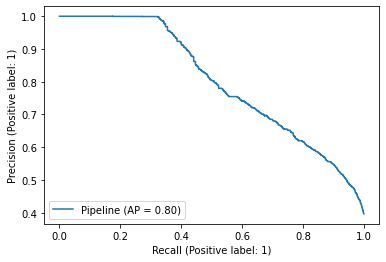

In [121]:
plot_precision_recall_curve(estimator_balance,x_test,y_test)

In [113]:
estimator_balance.fit(x_train,y_train)
y_pred = estimator_balance.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.78      0.81     22424
           1       0.67      0.73      0.69     13246

    accuracy                           0.76     35670
   macro avg       0.75      0.76      0.75     35670
weighted avg       0.77      0.76      0.76     35670



## After Tuning

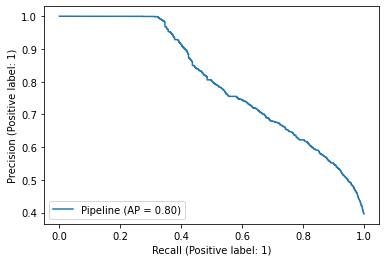

In [122]:
plot_precision_recall_curve(random_search.best_estimator_,x_test,y_test)

In [114]:
random_search.best_estimator_.fit(x_train, y_train)
y_pred = random_search.best_estimator_.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81     22424
           1       0.67      0.73      0.70     13246

    accuracy                           0.76     35670
   macro avg       0.75      0.76      0.75     35670
weighted avg       0.77      0.76      0.77     35670



Before dan after tuning: tidak ada perbedaan signifikan baik di recall score, maupun di precision-recall curve. Hasil F1 score meningkat setelah hyperparameter tuning. Untuk kedepannya, dapat mencoba membuat model dengan metric evaluasi F1 score.

## Saving Model with Pickle

In [115]:
import pickle

In [116]:
random_search.best_estimator_.fit(x, y)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['hotel', 'deposit_type',
                                                   'customer_type']),
                                                 ('binary', BinaryEncoder(),
                                                  ['meal', 'country',
                                                   'market_segment',
                                                   'distribution_channel',
                                                   'reserved_room_type'])])),
                ('balancing', SMOTE(k_neighbors=20, random_state=2020)),
                ('model',
                 LogisticRegression(C=10, max_iter=10000, solver='newton-cg'))])

In [117]:
file_name = 'ujian.sav'

pickle.dump(random_search.best_estimator_, open(file_name,'wb'))

In [118]:
loaded_model = pickle.load(open(file_name,'rb'))
loaded_model.predict(x_test)

array([0, 0, 1, ..., 0, 0, 1])

# Kesimpulan


Setelah hyperparameter tuning, performa model tidak meningkat secara signifikan. Hal ini dikarenakan model dihyperparameter tuning menggunakan RandomizedSearch, bukan GridSearch. GridSearch akan mendapatkan hyperparameter tuning yang parameter yang terbaik, namun hyperparameter tuning dengan GridSearch membutuhkan waktu yang lama karena GridSearch akan mencoba semua kombinasi parameter yang kita masukkan. Kesimpulan: model LogisticRegression dengan metode balancing SMOTE tanpa hyperparameter tuning dapat digunakan sebagai model memprediksi user cancel booking atau tidak dengan recall score 0.73. Untuk perbaikan/improvement model, ada beberapa suggestions yang dapat dilakukan:

 - Hyperparameter Tuning dengan GridSearch
 - Pemilihan parameter lain selain k neighbors, solver, dan C
 - Feature Selection atau dimension reduction dengan PCA
 - Evaluasi dengan model K Neighbors dan hyperparameter tuning dengan parameternya untuk membandingkan score metric evaluasinya
 - Menggunakan F1 score sebagai metric evaluasi, melihat curve precision dan recall trade off yang cenderung smooth dan nilai f1 score yang meningkat setelah hyperparameter tuning
 

#### Further Suggestions: Feature Selection using eli5

In [123]:
import eli5

In [131]:
features = list(transformer.transformers_[0][1].get_feature_names()) + transformer.transformers_[1][1].get_feature_names() + ['adults','children','babies','booking_changes','days_in_waiting_list','required_car_parking_spaces','total_of_special_requests']
features

['x0_Resort Hotel',
 'x1_Non Refund',
 'x1_Refundable',
 'x2_Group',
 'x2_Transient',
 'x2_Transient-Party',
 'meal_0',
 'meal_1',
 'meal_2',
 'meal_3',
 'country_0',
 'country_1',
 'country_2',
 'country_3',
 'country_4',
 'country_5',
 'country_6',
 'country_7',
 'country_8',
 'market_segment_0',
 'market_segment_1',
 'market_segment_2',
 'market_segment_3',
 'distribution_channel_0',
 'distribution_channel_1',
 'distribution_channel_2',
 'distribution_channel_3',
 'reserved_room_type_0',
 'reserved_room_type_1',
 'reserved_room_type_2',
 'reserved_room_type_3',
 'reserved_room_type_4',
 'adults',
 'children',
 'babies',
 'booking_changes',
 'days_in_waiting_list',
 'required_car_parking_spaces',
 'total_of_special_requests']

In [132]:
eli5.explain_weights(estimator_balance.named_steps['model'], top=50, feature_names=features)

Weight?,Feature
+5.238,x1_Non Refund
+0.562,distribution_channel_3
+0.483,x2_Transient
+0.405,reserved_room_type_1
+0.403,adults
+0.353,reserved_room_type_2
+0.248,reserved_room_type_4
+0.242,children
+0.162,x1_Refundable
+0.128,country_2


eli5 memberikan list feature-feature mana yang paling memberikan impact untuk prediksi, sehingga untuk pembuatan model selanjutnya dapat menggunakan feature-feature yang paling berbobot seperti deposit type, distribution channel, customer type, reserved room type, dan adults